In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

old_dataset = "data/filesplit2/"
old_testset = "data/test/"
kaggle_set_folder = "data/kaggle_set_folder"
kaggle_test_set_folder = "data/kaggle_test_set_folder"
small_kaggle_set_folder = "data/small_kaggle_set_folder"
small_kaggle_test_set_folder = "data/small_kaggle_test_set_folder"
history_set_folder = "data/history_set_folder"
history_test_set_folder = "data/history_test_set_folder"
combined_set_folder = "data/combined_set_folder"
combined_test_set_folder = "data/combined_test_set_folder"
MODELS_FOLDER = "IA_models"

MODEL_NAME = "combined.h5"
MAX_FEATURES = 2000
BATCH_SIZE = 128
EPOCHS = 15
OUTPUT_DIM = 10
TRAIN_SET = combined_set_folder
TEST_SET = combined_test_set_folder

SEQUENCE_LENGTH = 150
SEED = 42

In [2]:
raw_train_data = tf.keras.preprocessing.text_dataset_from_directory(TRAIN_SET, batch_size=BATCH_SIZE,
                                                                    validation_split=0.2, subset="training",
                                                                    label_mode="binary", seed=SEED)
raw_val_data = tf.keras.preprocessing.text_dataset_from_directory(TRAIN_SET, batch_size=BATCH_SIZE,
                                                                  validation_split=0.2, subset="validation",
                                                                  label_mode="binary", seed=SEED)
raw_test_data = tf.keras.preprocessing.text_dataset_from_directory(TEST_SET, batch_size=BATCH_SIZE)

Found 71578 files belonging to 2 classes.
Using 57263 files for training.
Found 71578 files belonging to 2 classes.
Using 14315 files for validation.
Found 2490 files belonging to 2 classes.


In [3]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )


vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)
text_ds = raw_train_data.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE)
vectorize_layer.adapt(text_ds)


def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [4]:
train_ds = raw_train_data.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = raw_val_data.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_data.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
#standard model
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, output_dim=OUTPUT_DIM),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])
model.summary()

model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          20010     
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 20,021
Trainable params: 20,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
448/448 [==============================] - 7s 11ms/step - loss: 0.5827 - binary_accuracy: 0.7584 - val_loss

In [6]:
complete_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("sigmoid")
])

complete_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']
)

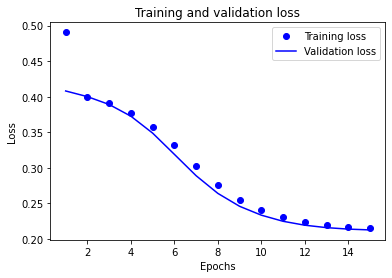

In [7]:
#PLOT LOSS
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

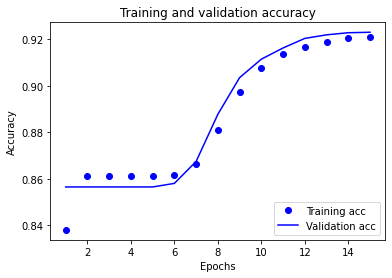

In [8]:
#PLOT ACCURACY
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [9]:
#EVALUATION
loss, accuracy = model.evaluate(test_ds)
print("Base Model")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

loss, accuracy = complete_model.evaluate(raw_val_data)
print("Complete Model")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

20/20 [==============================] - 1s 30ms/step - loss: 0.2359 - binary_accuracy: 0.8952
Base Model
Loss:  0.23590776324272156
Accuracy:  0.8951807022094727
112/112 [==============================

In [10]:
#Test on some value
def adapt(url: str):
    return url.ljust(75, " ").replace("", " ")[1: 151]


test = [
    #Should be malicious urls
    adapt("https://crackyourgames.com/"),
    adapt("https://fitgirl-repacks.to/"),
    adapt("http://eliteloungegroup.com.au/sample/"),
    adapt("http://neverclick.net/uw45692d61/367c70453965c3e5c2ab1f6d/index.php?id=5e63"),
    adapt("http://iitp.org.br/invel/wp-includes/quotationfile/doc/dxx/b727e1fe915abd93"),
    #Should be valid urls
    adapt("https://www.reddit.com/r/gamedev/wiki/getting_started#wiki_you_must_learn_how_to_seek_out_resources"),
    adapt("https://www.twitch.tv/"),
    adapt("https://www.lebigdata.fr/cryptbb-dark-web-tout-savoir"),
    adapt("https://bitwarden.com/browser-start/"),
    adapt("https://stackoverflow.com/"),
    adapt("https://stackoverflow.com/questions/59285984/custom-layer-in-keras-dimension-problem"),
    adapt("https://ent2.utt.fr/uPortal/render.userLayoutRootNode.uP")
]

complete_model.predict(test)

array([[0.55012304],
       [0.44351822],
       [0.18607272],
       [0.03686631],
       [0.14304861],
       [0.9959708 ],
       [0.9740863 ],
       [0.96643114],
       [0.915751  ],
       [0.81460387],
       [0.98734933],
       [0.39816365]], dtype=float32)

In [11]:
#Test on all history
raw_history_data = tf.keras.preprocessing.text_dataset_from_directory(history_set_folder, batch_size=BATCH_SIZE,
                                                                      label_mode="binary", seed=SEED)
raw_history_test_data = tf.keras.preprocessing.text_dataset_from_directory(history_test_set_folder,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="binary", seed=SEED)
raw_kaggle_test_data = tf.keras.preprocessing.text_dataset_from_directory(kaggle_test_set_folder, batch_size=BATCH_SIZE,
                                                                          label_mode="binary", seed=SEED)
raw_combined_data = tf.keras.preprocessing.text_dataset_from_directory(combined_set_folder, batch_size=BATCH_SIZE,
                                                                       label_mode="binary", seed=SEED)
raw_combined_test_data = tf.keras.preprocessing.text_dataset_from_directory(combined_test_set_folder,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="binary", seed=SEED)

loss, history_accuracy = complete_model.evaluate(raw_history_data)
loss, history_test_accuracy = complete_model.evaluate(raw_history_test_data)
loss, kaggle_test_accuracy = complete_model.evaluate(raw_kaggle_test_data)
loss, combined_accuracy = complete_model.evaluate(raw_combined_data)
loss, combined_test_accuracy = complete_model.evaluate(raw_combined_test_data)
print(f"Accuracy for history: {history_accuracy}")
print(f"Accuracy for history test: {history_test_accuracy}")
print(f"Accuracy for kaggle test: {kaggle_test_accuracy}")
print(f"Accuracy for combined: {combined_accuracy}")
print(f"Accuracy for combined test: {combined_test_accuracy}")

Found 21576 files belonging to 2 classes.
Found 1488 files belonging to 2 classes.
Found 44953 files belonging to 2 classes.
Found 71578 files belonging to 2 classes.
Found 2490 files belonging to 2 classes.
20/20 [==============================] - 0s 4ms/step - loss: 0.2359 - accuracy: 0.8952
Accuracy for history: 0.74800705909729
Accuracy for history test: 0.8259408473968506
Accuracy for kaggle test: 0.909994900226593
Accuracy for combined: 0.9225180745124817
Accuracy for combined test: 0.8951807022094727


In [12]:
#SAVE MODEL
model.save(f"{MODELS_FOLDER}/{MODEL_NAME}")